<h1 style="text-align: center;">FEM on bounded domains</h1>

This notebook shows how to run finite element computations on bounded domains with *femtoscope*.

*prerequisites* :
- FEM knowledge
- Mesh Generation notebook

The following code is adapted from scripts provided in the same directory as this notebook.

**If you have questions/comments or want to report a bug, please send me an email at <a href="mailto:hugo.levy@onera.fr">hugo.levy@onera.fr</a>**

In [1]:
# Add femtoscope to the path
%reset
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Poisson's equation [the linear case]

Given a domain $\Omega$ with boundary $\Gamma$, we wish to solve the following problem
$$
\begin{cases} 
  \Delta u = \rho & \text{in } \Omega\\
  u(\mathbf{x}) = g(\mathbf{x}) & \text{for } \mathbf{x} \in \Gamma
\end{cases} \, ,
$$
which is simply a Poisson's equation subjected to some Dirichlet boundary condition. In the framework of Newtonian gravity, this equation is (up to a multiplicative constant) satisfied by the so-called Newtonian Potential $\Phi$. This is why in *femtoscope*, all the weak formulations are implemented in the class `PoissonBounded`.

**Warning** Note that here, the Laplacian symbol $\Delta$ refers to the standard 3-dimensional Laplacian operator, i.e. such that $$ \Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2} \, .$$ What is advertized as '1D computation' and '2D computation' down below result from dimensional reduction allowed by some symmetry in the density distribution [1].

[1] https://arxiv.org/abs/2209.07226

In [2]:
from femtoscope.physics.poisson import PoissonBounded
from matplotlib import pyplot as plt
import numpy as np

#### 1D computation

        Solver:
            # weak-form(s): 1
            bounded domain
            is linear?: YES



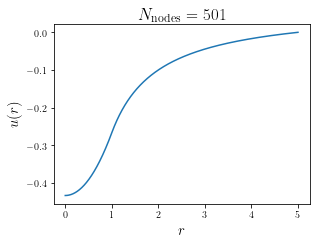

In [3]:
# 1) Mesh definition

from sfepy.examples.dg.example_dg_common import get_gen_1D_mesh_hook

Rcut = 5.0
X1 = 0.0
XN = Rcut
n_nod = int(100*Rcut) + 1
n_el = n_nod - 1
mesh = get_gen_1D_mesh_hook(X1, XN, n_nod).read(None)


# 2) Setting-up the FEM problem

def rho_func(r):
    return np.where(r<=1.0, 1.0, 0.0)

def bord_Rcut(r, domain=None):
    return np.where(r==Rcut)[0]

ent_func = [(0, bord_Rcut)]
densities = [rho_func]
dirichlet_bc = [0.0]
pb = PoissonBounded(1.0, densities, dirichlet_bc, mesh, coorsys='polar',
                    entity_functions=ent_func, fem_order=2, verbose=True)

# 3) Solving
pb.solve()

# 3) Post-processing and plot
sol_1D = pb.solver.sols[0]
field_1D = pb.solver.weakforms[0].field
rr = field_1D.coors.squeeze()
indsort = rr.argsort()
sol_1D = sol_1D[indsort]
rr = rr[indsort]

plt.figure(figsize=(4.5,3.5))
plt.plot(rr, sol_1D)
plt.xlabel(r"$r$", fontsize=15)
plt.ylabel(r"$u(r)$", fontsize=15)
plt.title(r"$N_{\mathrm{nodes}} = %d$ " %n_nod, fontsize=17)
plt.tight_layout()
plt.show()

Let's comment the above portion of code step by step:
1. Mesh definition 

$\longrightarrow$ see the notebook dedicated to mesh generation

2. Setting-up the FEM problem

We need to create a problem instance, more specifically a `PoissonBounded` instance. Please have a look at the constructor docstring to get the meaning of each argument.
- The density distribution $\rho(\mathbf{x})$ is given by the function `rho_func`. The `densities` list should contain as many elements (floats or functions) as there are subdomains. In this particular example, there is a single domain $\Omega = [0, R_{\mathrm{cut}}]$.
- Because we provide only one entity function `ent_func`, we have to provide only one Dirichlet boundary condition in the `dirichlet_bc` list (which is homogeneous in the above example). It is applied at $r = R_{\mathrm{cut}} = 5$.

3. Solving

Once the problem has been set up, it can be solved simply by calling the `solve` method.

4. Post-processing and plot

The solution vector is retrieved with `sol_1D = pb.solver.sols[0]` while the corresponding coordinates are retrieved with `field_1D = pb.solver.weakforms[0].field` and `rr = field_1D.coors.squeeze()`. Because we used `fem_order = 2` (i.e. second order Lagrange piecewise polynomials), the coordinates are not necessarily sorted, which is why we sort them before plotting the numerical approximation

#### 2D computation

2D computations can be performed in several coordinate systems, namely:
- Cartesian coordinates $(x, y) \in \mathbb{R}^2$
- polar coordinates $(r, \theta) \in \mathbb{R}^+ \times [0, \pi]$
- "polar-mu" coordinates $(r, \mu)$ where $\mu = \cos (\theta) \in [-1, 1]$

This image illustrates the three coordinate systems.
<img src="../images/cart_and_polar.png" alt="isolated" width="800"/>

In [4]:
from femtoscope.inout.meshfactory import MeshingTools, mesh_from_geo
from numpy import sqrt, cos, sin, pi
Rcut = 5.0
rho = 1.0
alpha = 1.0

# select coordinate system
coorsys = 'cartesian' # should be in ['cartesian', 'polar', 'polar_mu']

if coorsys == 'cartesian':

    # 1) mesh generation
    Ngamma = 300
    sa = 1.0
    sc = 0.7
    meshfile = 'mesh_cartesian.vtk'
    MT = MeshingTools(dimension=2)
    s1 = MT.create_ellipse(sa, sc, xc=0, yc=0)
    MT.create_subdomain(CellSizeMin=0.05, CellSizeMax=0.2, DistMin=sa/5, DistMax=3*sa)
    s2 = MT.create_disk_from_pts(Rcut, N=Ngamma) # impose vertices on gamma
    s12 = MT.subtract_shapes(s2, s1, removeObject=True, removeTool=False)
    MT.create_subdomain(CellSizeMin=0.1, CellSizeMax=0.3, DistMax=0.0)
    MT.generate_mesh(meshfile, show_mesh=True, ignoreTags=[200], symmetry=True, embed_center=False)
    
    # 2) Setting-up the FEM problem
    densities = [rho, 0.0]
    dirichlet_bc = [0.0]

    pb = PoissonBounded(alpha, densities, dirichlet_bc, meshfile,
                        coorsys=coorsys, fem_order=2, verbose=True)

elif coorsys == 'polar':

    # 1) mesh generation
    meshfile = "mesh_theta.vtk"
    mesh_from_geo('mesh_theta.geo', show_mesh=True,
                  param_dic={'size' : 0.1, 'Rc' : Rcut, 'sa' : 1.0})

    # 2) Setting-up the FEM problem
    def rho_func(coors):
        value = np.zeros(coors.shape[0])
        norm2 = coors[:,0]**2
        theta = coors[:, 1]
        boolin = np.where(norm2*((sin(theta)/sa)**2+(cos(theta)/sc)**2)<1)[0]
        value[boolin] = rho
        return value

    densities = [rho_func]
    dirichlet_bc = [0.0]
    pb = PoissonBounded(alpha, densities, dirichlet_bc, meshfile,
                        coorsys=coorsys, fem_order=2, verbose=True)

elif coorsys == 'polar_mu':
    
    # 1) mesh generation
    meshfile = "mesh_mu.vtk"
    mesh_from_geo('mesh_mu.geo', show_mesh=True,
                  param_dic={'size' : 0.1, 'Rc' : Rcut, 'sa' : 1.0})
    
    # 2) Setting-up the FEM problem
    def rho_func(coors):
        value = np.zeros(coors.shape[0])
        norm2 = coors[:,0]**2
        mu = coors[:, 1]
        sin_theta = sqrt(1-mu**2)
        boolin = np.where(norm2*((sin_theta/sa)**2+(mu/sc)**2)<1)[0]
        value[boolin] = rho
        return value

    densities = [rho_func]
    dirichlet_bc = [0.0]
    pb = PoissonBounded(alpha, densities, dirichlet_bc, meshfile,
                        coorsys=coorsys, fem_order=2, verbose=True)
    
else:
    raise ValueError("coorsys = {} is not implemented".format(coorsys))

# 3) Solving
pb.solve()

# 4) show and save
# Pyvista does not behave very well in jupyter notebooks so we only save
# the plots as image files. The default location is data\result\plot.
pb.plot(save=True, show=False, name='2D-{}-poisson'.format(coorsys))

        Solver:
            # weak-form(s): 1
            bounded domain
            is linear?: YES



An important feature of Sfepy is the evaluation of the solution anywhere in the numerical domain using basis functions (i.e. the discrete, finite dimensional functional space). We show how to evaluate the solution and its gradient along a radial line.

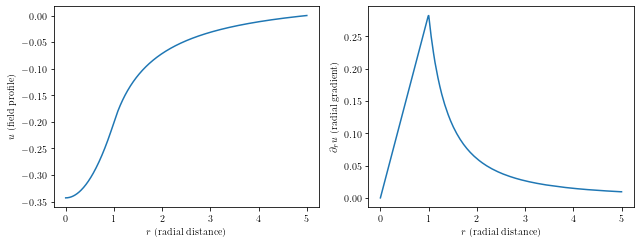

In [5]:
# Retrieve the solution vector and the Sfepy's `field` instance
sol = pb.solver.sols[0]
field = pb.solver.weakforms[0].field
Npt = 500

# Define the line along which we want to evaluate the field and its gradient along this line
if coorsys == 'cartesian':
    XX = np.linspace(0, Rcut, Npt)
    YY = np.zeros_like(XX)
    coors = np.concatenate((XX[:, np.newaxis], YY[:, np.newaxis]), axis=1)
    
elif coorsys in ['polar', 'polar_mu']:
    RR = np.linspace(0, Rcut, Npt)
    AA = pi/2*np.ones_like(RR) if coorsys=='polar' else np.zeros_like(RR)
    coors = np.concatenate((RR[:, np.newaxis], AA[:, np.newaxis]), axis=1)
    
else:
    raise ValueError("coorsys = {} is not implemented".format(coorsys))

# Use Sfepy's routine `field.evaluate_at`
profile = field.evaluate_at(coors, sol[:, np.newaxis], mode='val').squeeze()
grad_r = field.evaluate_at(coors, sol[:, np.newaxis], mode='grad').squeeze()[:, 0]

# Plot
fig, axs = plt.subplots(figsize=(9, 3.5), nrows=1, ncols=2)
axs[0].plot(coors[:, 0], profile)
axs[0].set_xlabel(r"$r$ (radial distance)")
axs[0].set_ylabel(r"$u$ (field profile)")
axs[1].plot(coors[:, 0], grad_r)
axs[1].set_xlabel(r"$r$ (radial distance)")
axs[1].set_ylabel(r"$\partial_r u$ (radial gradient)")
plt.tight_layout()
plt.show()

#### 3D computation

3D computation is currently available only in Cartesian coordinates $(x,y,z)$. There is no fundamental difference between 2D and 3D in terms of scripting. As 3D computations are much more computationally expensive than 2D, we try to avoid having to resort to them as much as possible.

In [6]:
# 1) mesh generation
meshfile = 'sphere.vtk'
MT = MeshingTools(dimension=3)
s1 = MT.create_ellipsoid(sa, sa, sa)
MT.create_subdomain(CellSizeMin=0.5, CellSizeMax=0.5, DistMin=sa/5,
                    DistMax=3*sa)
s2 = MT.create_ellipsoid(Rcut, Rcut, Rcut)
s12 = MT.subtract_shapes(s2, s1, removeObject=True, removeTool=False)
MT.create_subdomain(CellSizeMin=0.5, CellSizeMax=0.7, DistMax=0.0)
out = MT.generate_mesh(meshfile, show_mesh=True, convert=True,
                       ignoreTags=[200], embed_center=False)

# 2) Setting-up the FEM problem
densities = [rho, 0]
dirichlet_bc = [0.0]

pb = PoissonBounded(alpha, densities, dirichlet_bc, meshfile,
                    coorsys='cartesian', fem_order=2, verbose=True)

# 3) Solving
pb.solve()

        Solver:
            # weak-form(s): 1
            bounded domain
            is linear?: YES



## Klein-Gordon equation [the nonlinear case]

Given a domain $\Omega$ with boundary $\Gamma$, we wish to solve the following problem
$$
\begin{cases} 
  \alpha \Delta \phi = \rho - \phi^{-(n+1)} & \text{in } \Omega\\
  \phi(\mathbf{x}) = g(\mathbf{x}) & \text{for } \mathbf{x} \in \Gamma
\end{cases} \, ,
$$
which is a nonlinear Klein-Gordon equation with Dirichlet boundary condition prescribed on the boundary $\Gamma$. This equation is satisfied by the chameleon field (in its dimensionless form), which is why in *femtoscope* the weak formulations are implemented in the class `ChameleonBounded`. The nonlinearity is handled by means of the Newton method, which works by solving a sequence of linear problems that eventually converges towards the *true* solution. The syntax to solve this kind of problems is very similar to what we have seen above, except that now the user can tweak additional parameters such as *the initial guess*, *the relaxation parameter*, *the maximum number of iterations*, etc.

In the examples down below, we compute the profile of the chameleon field sourced by a perfect solid sphere of densitiy $\rho_{\mathrm{in}}$ immersed in a fluid of density $\rho_{\mathrm{out}}$.

In [7]:
from femtoscope.physics.chameleon import ChameleonBounded
from matplotlib import pyplot as plt
import numpy as np

In [8]:
from femtoscope.inout.meshfactory import MeshingTools, mesh_from_geo
from numpy import sqrt, cos, sin, pi
verbose = True

# parameter (geometric, densities, chameleon...)
Rcut = 5.0 # truncation radius
R_ball = 1.0 # radius of the ball
rho_in = 1e2 # density inside the ball
rho_out = 0.1 # density outside the ball
rho_bounds = [rho_out, rho_in]
npot = 1 # exponent parameter of the chameleon model
phi_bounds = [rho_in**(-1/(npot+1)), rho_out**(-1/(npot+1))]
phi_min, phi_max = phi_bounds[0], phi_bounds[1]
alpha = 1e-2 # dimensionless constant
dirichlet_bc = [phi_max] # Dirichlet boundary condition

analytic_params = {'R_A' : R_ball,
                   'rho_in' : rho_bounds[1],
                   'rho_vac' : rho_bounds[0]}

# select coordinate system
coorsys = 'polar_mu' # should be in ['cartesian', 'polar', 'polar_mu']

if coorsys == 'cartesian':

    # 1) mesh generation
    Ngamma = 300
    sa = 1.0
    sc = 1.0
    meshfile = 'mesh_cartesian.vtk'
    MT = MeshingTools(dimension=2)
    s1 = MT.create_ellipse(sa, sc, xc=0, yc=0)
    MT.create_subdomain(CellSizeMin=0.05, CellSizeMax=0.2, DistMin=sa/5, DistMax=3*sa)
    s2 = MT.create_disk_from_pts(Rcut, N=Ngamma) # impose vertices on gamma
    s12 = MT.subtract_shapes(s2, s1, removeObject=True, removeTool=False)
    MT.create_subdomain(CellSizeMin=0.1, CellSizeMax=0.3, DistMax=0.0)
    MT.generate_mesh(meshfile, show_mesh=True, ignoreTags=[200], symmetry=True, embed_center=False)
    
    densities = [rho_in, rho_out]

elif coorsys == 'polar':

    # 1) mesh generation
    meshfile = "mesh_theta.vtk"
    mesh_from_geo('mesh_theta.geo', show_mesh=True,
                  param_dic={'size' : 0.05, 'Rc' : Rcut, 'sa' : 1.0})

    def rho_func(coors):
        value = rho_out * np.ones(coors.shape[0])
        norm2 = coors[:,0]**2
        theta = coors[:, 1]
        boolin = np.where(norm2*((sin(theta)/sa)**2+(cos(theta)/sc)**2)<1)[0]
        value[boolin] = rho_in
        return value

    densities = [rho_func]

elif coorsys == 'polar_mu':
    
    # 1) mesh generation
    meshfile = "mesh_mu.vtk"
    mesh_from_geo('mesh_mu.geo', show_mesh=True,
                  param_dic={'size' : 0.05, 'Rc' : Rcut, 'sa' : 1.0})

    def rho_func(coors):
        value = rho_out * np.ones(coors.shape[0])
        norm2 = coors[:,0]**2
        mu = coors[:, 1]
        sin_theta = sqrt(1-mu**2)
        boolin = np.where(norm2*((sin_theta/sa)**2+(mu/sc)**2)<1)[0]
        value[boolin] = rho_in
        return value

    densities = [rho_func]
    
else:
    raise ValueError("coorsys = {} is not implemented".format(coorsys))
    
# 2) Setting-up the FEM problem
pb = ChameleonBounded(alpha, npot, densities, dirichlet_bc, rho_bounds, meshfile, coorsys=coorsys,
                      fem_order=2, verbose=verbose, analytic_params=analytic_params, min_iter=5,
                      max_iter=200, relax=0.7, initial_guess=None, func_init=None)

# 3) Solving
pb.solve()

# 4) show and save
# Pyvista does not behave very well in jupyter notebooks so we only save
# the plots as image files. The default location is data\result\plot.
# pb.plot(save=True, show=False, name='2D-{}-chameleon'.format(coorsys))



        Solver:
            # weak-form(s): 1
            bounded domain
            is linear?: NO
            relax parameter: 0.7
        Stop Criteria:
            max iter: 200
            relative delta_sol tolerance: 1e-14
            relative delta_res tolerance: 1e-14

************ Iteration no 0 ************
Sol rel delta     NAN
Residual L2       1.262E+00
Residual mean     2.534E-03
Residual inf      7.039E-02
Residual rel delta NAN

************ Iteration no 1 ************
Sol rel delta     3.912E-01
Residual L2       1.130E+00
Residual mean     2.049E-03
Residual inf      7.968E-02
Residual rel delta 1.359E+00

************ Iteration no 2 ************
Sol rel delta     8.312E-02
Residual L2       6.169E-01
Residual mean     1.113E-03
Residual inf      4.373E-02
Residual rel delta 4.550E-01

************ Iteration no 3 ************
Sol rel delta     9.598E-02
Residual L2       3.371E-01
Residual mean     6.045E-04
Residual inf      2.401E-02
Residual rel delta 4.563E-01

*

There are several ways to initialize the Newton's iterations. The $\mathrm{0^{th}}$ iteration is called *the initial guess* and should be provided by the user. There are 5 different ways to set the initial guess in *femtoscope*:
1. If `analytic_params` is passed as an argument, the initial guess is computed using some analytical approximation of the chameleon field around a spherical object (which is implemented in `femtoscope.misc.analytical`).
2. If we set `initial_guess='min_pot'`, the field is initialized with the value of field that minimizes the effective potential,  i.e. $\phi_{\text{min pot}} = \rho^{-1/(n+1)}$. It is often a good initialization in the strong screened regime.
3. If we set `initial_guess` to be a 1D numpy array, then the field is initialized *as is*. It is up to the user to make sure that the input array is consistent with the number and coordinates of the mesh DOFs.
4. If we set the argument `func_init`, the initial guess is computed with a function call `func_init(coors)`.
5. If no argument is passed, the field is initialized at a constant value computed as $\left(\rho_{\mathrm{in}}^{-1/(n+1)} + \rho_{\mathrm{out}}^{-1/(n+1)}\right)/2$.

Finally, we can evaluate the field at any location in the mesh exactly as done before:

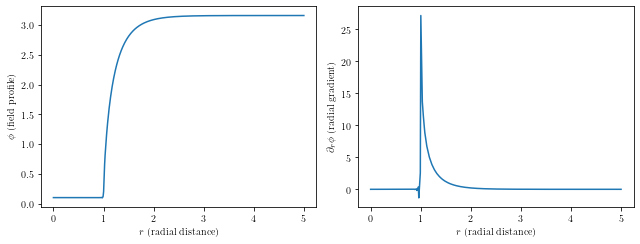

In [9]:
# Retrieve the solution vector and the Sfepy's `field` instance
sol = pb.solver.sols[0]
field = pb.solver.weakforms[0].field
Npt = 500

# Define the line along which we want to evaluate the field and its gradient along this line
if coorsys == 'cartesian':
    XX = np.linspace(0, Rcut, Npt)
    YY = np.zeros_like(XX)
    coors = np.concatenate((XX[:, np.newaxis], YY[:, np.newaxis]), axis=1)
    
elif coorsys in ['polar', 'polar_mu']:
    RR = np.linspace(0, Rcut, Npt)
    AA = pi/2*np.ones_like(RR) if coorsys=='polar' else np.zeros_like(RR)
    coors = np.concatenate((RR[:, np.newaxis], AA[:, np.newaxis]), axis=1)
    
else:
    raise ValueError("coorsys = {} is not implemented".format(coorsys))

# Use Sfepy's routine `field.evaluate_at`
profile = field.evaluate_at(coors, sol[:, np.newaxis], mode='val').squeeze()
grad_r = field.evaluate_at(coors, sol[:, np.newaxis], mode='grad').squeeze()[:, 0]

# Plot
fig, axs = plt.subplots(figsize=(9, 3.5), nrows=1, ncols=2)
axs[0].plot(coors[:, 0], profile)
axs[0].set_xlabel(r"$r$ (radial distance)")
axs[0].set_ylabel(r"$\phi$ (field profile)")
axs[1].plot(coors[:, 0], grad_r)
axs[1].set_xlabel(r"$r$ (radial distance)")
axs[1].set_ylabel(r"$\partial_r \phi$ (radial gradient)")
plt.tight_layout()
plt.show()